In [1]:
# Import Libraries
import cv2
import os
from glob import glob

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential #for neural network models
from keras.layers import Input, Dense, Flatten,Conv2D, ZeroPadding2D, MaxPooling2D, Dropout
from keras.layers import Conv2DTranspose, SeparableConv2D, BatchNormalization # Import hidden layer
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.optimizers import Adam #For Optimizing the Neural Network
from keras.applications.vgg16 import VGG16 # VGG16 saved model from keras
from keras import layers
from keras.layers import Input
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K

Using TensorFlow backend.


In [0]:
#use your dir for the data
ood_path = "/content/drive/My Drive/AI project/dataset/good/"
blurred_path = "/content/drive/My Drive/AI project/dataset/blurred/"

In [0]:
#Hyperparameters
mg_width = 64
img_height = 64
img_channel = 3
input_shape = (img_height,img_width,img_channel)
num_epochs = 10
batch_size = 32
noise_factor = 0.1

In [0]:
img_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,validation_split=0.25)


In [0]:
def noise_generator(batches, size):
    """Take as input a Keras ImageGen (Iterator) and generate random
    noise from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_noise = np.zeros((batch_x.shape[0], size, size, 3))
        for i in range(batch_x.shape[0]):
            batch_noise[i] = batch_x[i]+noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(size,size,3))
            batch_noise[i] = np.clip(batch_noise[i],0.,1.)
        yield (batch_noise, batch_y)

In [20]:
train_good = img_datagen.flow_from_directory(good_path,target_size=(img_width,img_height),
                                             class_mode='input',batch_size=batch_size,subset='training')
test_good = img_datagen.flow_from_directory(good_path,target_size=(img_width,img_height),
                                             class_mode='input',batch_size=batch_size,subset='validation')
train_blurred = img_datagen.flow_from_directory(blurred_path,target_size=(img_width,img_height),
                                             class_mode='input',batch_size=batch_size,subset='training')
test_blurred = img_datagen.flow_from_directory(blurred_path,target_size=(img_width,img_height),
                                             class_mode='input',batch_size=batch_size,subset='validation')

Found 1872 images belonging to 1 classes.
Found 624 images belonging to 1 classes.
Found 2304 images belonging to 1 classes.
Found 768 images belonging to 1 classes.


In [21]:
train_good.image_shape

(64, 64, 3)

In [0]:
blurred_noise_train = noise_generator(train_blurred,64)
blurred_noise_test = noise_generator(test_blurred,64)

In [26]:
batch_x, batch_y = next(blurred_noise_test)
batch_x.shape

(32, 64, 64, 3)

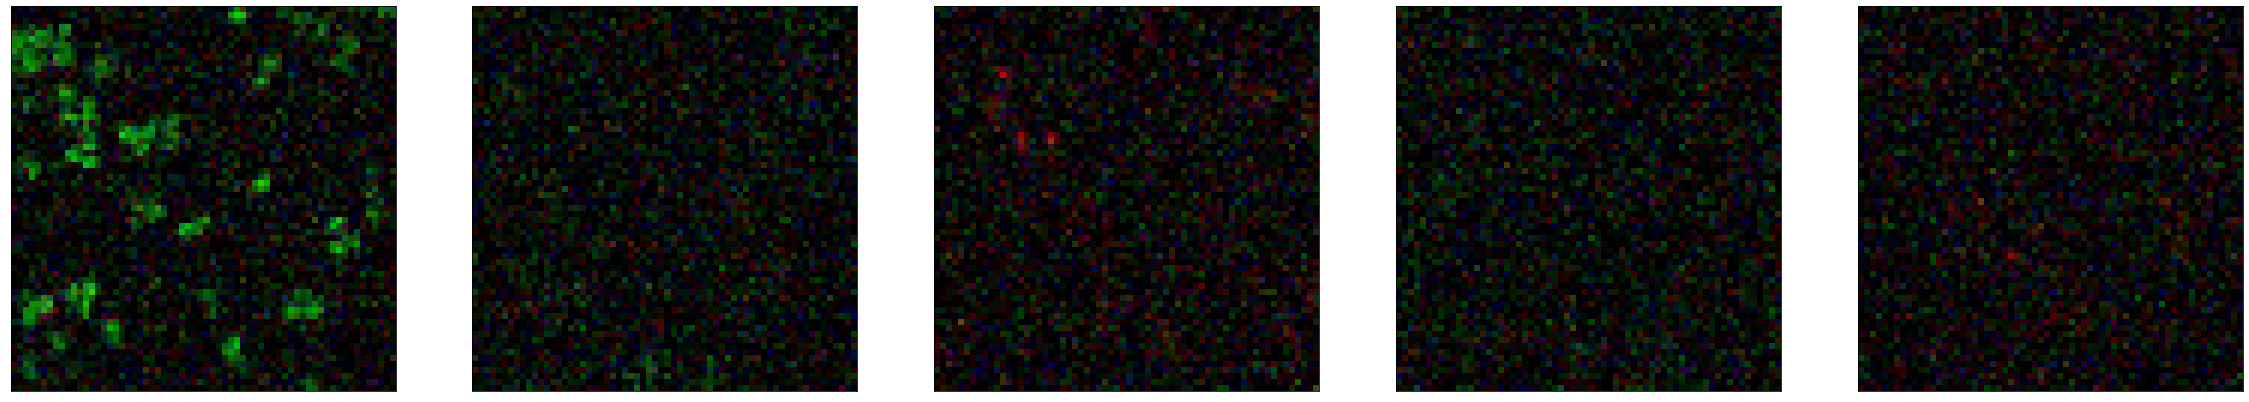

In [29]:
n = 5 # of images will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(batch_x[i].reshape(input_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [0]:
# create generators using zip() that will train orginal and noisy images 
train_generator = zip(train_good,blurred_noise_train)
test_generator = zip(test_good,blurred_noise_test)

In [31]:
#input shape
input_img = Input(input_shape) # adapt this if using `channels_first` image data format

#Encoder part
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.20)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.20)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#Decoder part
x = Conv2DTranspose(32, (2,2),padding='same', activation='relu',strides=(2, 2))(encoded)
x = Conv2DTranspose(64, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(64, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(128,(2,2),padding='same', activation='relu',strides=(2, 2))(x)
decoded = Conv2D(img_channel,(3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        3692

In [36]:
hist_test = autoencoder.fit_generator(train_generator,steps_per_epoch=8,
                                      epochs=num_epochs,
                                      validation_data=test_generator,verbose=1,
                                      validation_steps=8,
                                      shuffle=True,
                                      max_queue_size=5)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


KeyboardInterrupt: ignored